In [9]:
import sys
sys.path.append("..")
import ProbabilisticParcellation.util as ut
import ProbabilisticParcellation.hierarchical_clustering as cl
import ProbabilisticParcellation.similarity_colormap as cm
import ProbabilisticParcellation.functional_profiles as fp
from ProbabilisticParcellation.scripts.atlas_paper.ridge_reg import ridgeFit

from Functional_Fusion.dataset import *
import matplotlib.pyplot as plt
import string
import PcmPy as pcm
from copy import deepcopy
import torch as pt



base_dir = '/Volumes/diedrichsen_data$/data/FunctionalFusion'
if not Path(base_dir).exists():
    base_dir = '/srv/diedrichsen/data/FunctionalFusion'
if not Path(base_dir).exists():
    base_dir = '/Users/callithrix/Documents/Projects/Functional_Fusion/'
if not Path(base_dir).exists():
    raise (NameError('Could not find base_dir'))
    

## Load profile data and model

In [39]:
atlas = 'MNISymC2'

# load model
mname = f'/Models_03/sym_MdPoNiIbWmDeSo_space-{atlas}_K-32_meth-mixed'
fileparts = mname.split('/')
split_mn = fileparts[-1].split('_')
info, model = ut.load_batch_best(mname)


# load labels and cmap
lut_dir = '/Volumes/diedrichsen_data$/data/Cerebellum/ProbabilisticParcellationModel/Atlases/'
_, cmap, labels = nt.read_lut(lut_dir +
                              f'{fileparts[-1]}.lut')
labels=labels[1:]

# load profile
profile = pd.read_csv(
    f'{ut.model_dir}/Atlases/{fileparts[-1]}_profile.tsv', sep="\t"
)


In [3]:
# Reduce profile to only MDTB Tasks
profile = profile[profile.dataset == 'MDTB']

# Make profile into matrix
profile_mat = profile[labels].to_numpy()

# Normalize profile
profile_scaled = (profile_mat - np.mean(profile_mat, axis=0))


([<matplotlib.axis.YTick at 0x7fdc61b9e3d0>,
 [Text(0, 0, 'NoGo'),
  Text(0, 5, 'UnpleasantScenes'),
  Text(0, 10, 'SadFaces'),
  Text(0, 15, 'FingerSeq'),
  Text(0, 20, 'SpatialNavigation'),
  Text(0, 25, 'VisualSearchSmall'),
  Text(0, 30, 'Prediction'),
  Text(0, 35, 'SpatialNavigation'),
  Text(0, 40, 'RomanceMovie'),
  Text(0, 45, 'MentalRotMed'),
  Text(0, 50, 'BodyMotionScram'),
  Text(0, 55, 'VisualSearchMed'),
  Text(0, 60, 'rest')])

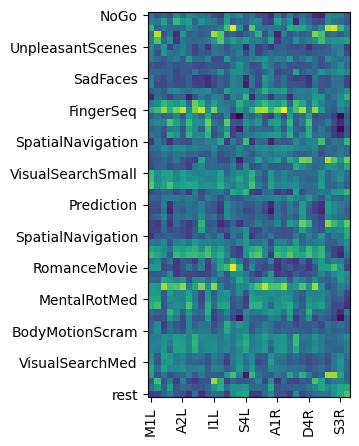

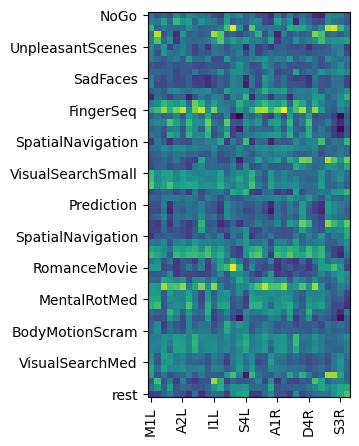

In [4]:
# Show profile

figsize = (5, 5)
# figsize = (40, 20)
plt.figure(figsize=figsize)
plt.imshow(profile_mat)
plt.xticks(np.arange(len(labels))[::5], labels[::5], rotation=90)
plt.yticks(np.arange(len(profile))[::5], profile.condition[::5])


# Show scaled profile
plt.figure(figsize=figsize)
plt.imshow(profile_scaled)
plt.xticks(np.arange(len(labels))[::5], labels[::5], rotation=90)
plt.yticks(np.arange(len(profile))[::5], profile.condition[::5])


### Load cognitive feature tags

In [5]:
# Load cognitive features
tags = pd.read_csv(
    f'{ut.model_dir}/Atlases/Profiles/tags/tags.csv', sep="\t"
)
tags = tags[tags.dataset == 'MDTB']
# Remove all tags after right_toe_response_execution
last_mdtb_tag = tags.columns.tolist().index('right_toe_response_execution')
tags = tags.iloc[:, :last_mdtb_tag]
tags_mat = tags[tags.columns[3:]].to_numpy()

# Reduce tags to only MDTB Tasks


In [6]:
# Subtract mean from each column and divide by standard deviation of each column
tags_mat = (tags_mat - np.mean(tags_mat, axis=0)) / np.std(tags_mat, axis=0)

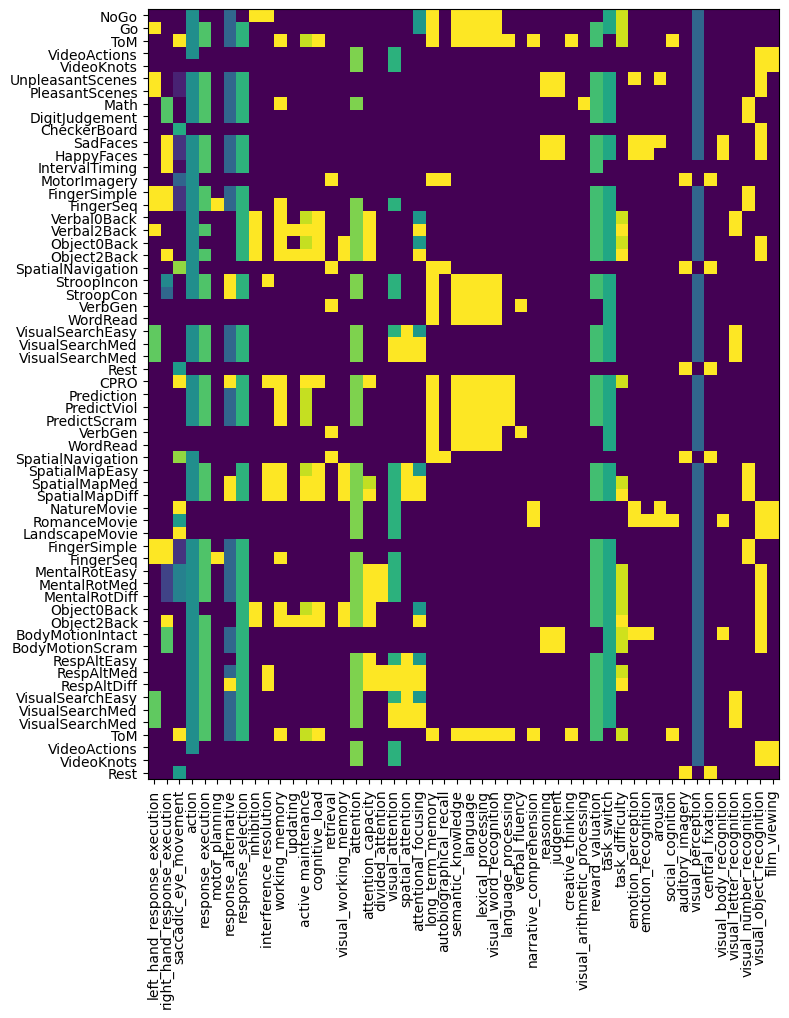

In [7]:
# Show features
plt.figure(figsize=(10, 10))
plt.imshow(tags_mat, vmin=0, vmax=1)
plt.xticks(np.arange(len(tags.columns[3:])), tags.columns[3:], rotation=90)
plt.yticks(np.arange(len(profile[profile.dataset == 'MDTB'])),
           tags[tags.dataset == 'MDTB'].condition)
# Make figure wider
plt.gcf().set_size_inches(100, 10)

In [10]:
R2, features = ridgeFit(profile_mat, tags_mat, fit_intercept=False, voxel_wise=False, alpha=1.0)
# Make dataframe with B values, profile.dataset, profile.condition, tags.columns[3:]
Features = pd.DataFrame(features.T, columns=tags.columns[3:], index=labels)



([<matplotlib.axis.YTick at 0x7fdc529ce9d0>,
 [Text(0, 0, 'left_hand_response_execution'),
  Text(0, 1, 'right_hand_response_execution'),
  Text(0, 2, 'saccadic_eye_movement'),
  Text(0, 3, 'action'),
  Text(0, 4, 'response_execution'),
  Text(0, 5, 'motor_planning'),
  Text(0, 6, 'response_alternative'),
  Text(0, 7, 'response_selection'),
  Text(0, 8, 'inhibition'),
  Text(0, 9, 'interference resolution'),
  Text(0, 10, 'working_memory'),
  Text(0, 11, 'updating'),
  Text(0, 12, 'active maintenance'),
  Text(0, 13, 'cognitive_load'),
  Text(0, 14, 'retrieval'),
  Text(0, 15, 'visual_working_memory'),
  Text(0, 16, 'attention'),
  Text(0, 17, 'attention_capacity'),
  Text(0, 18, 'divided_attention'),
  Text(0, 19, 'visual_attention'),
  Text(0, 20, 'spatial_attention'),
  Text(0, 21, 'attentional_focusing'),
  Text(0, 22, 'long_term_memory'),
  Text(0, 23, 'autobiographical_recall'),
  Text(0, 24, 'semantic_knowledge'),
  Text(0, 25, 'language'),
  Text(0, 26, 'lexical_processing'),
 

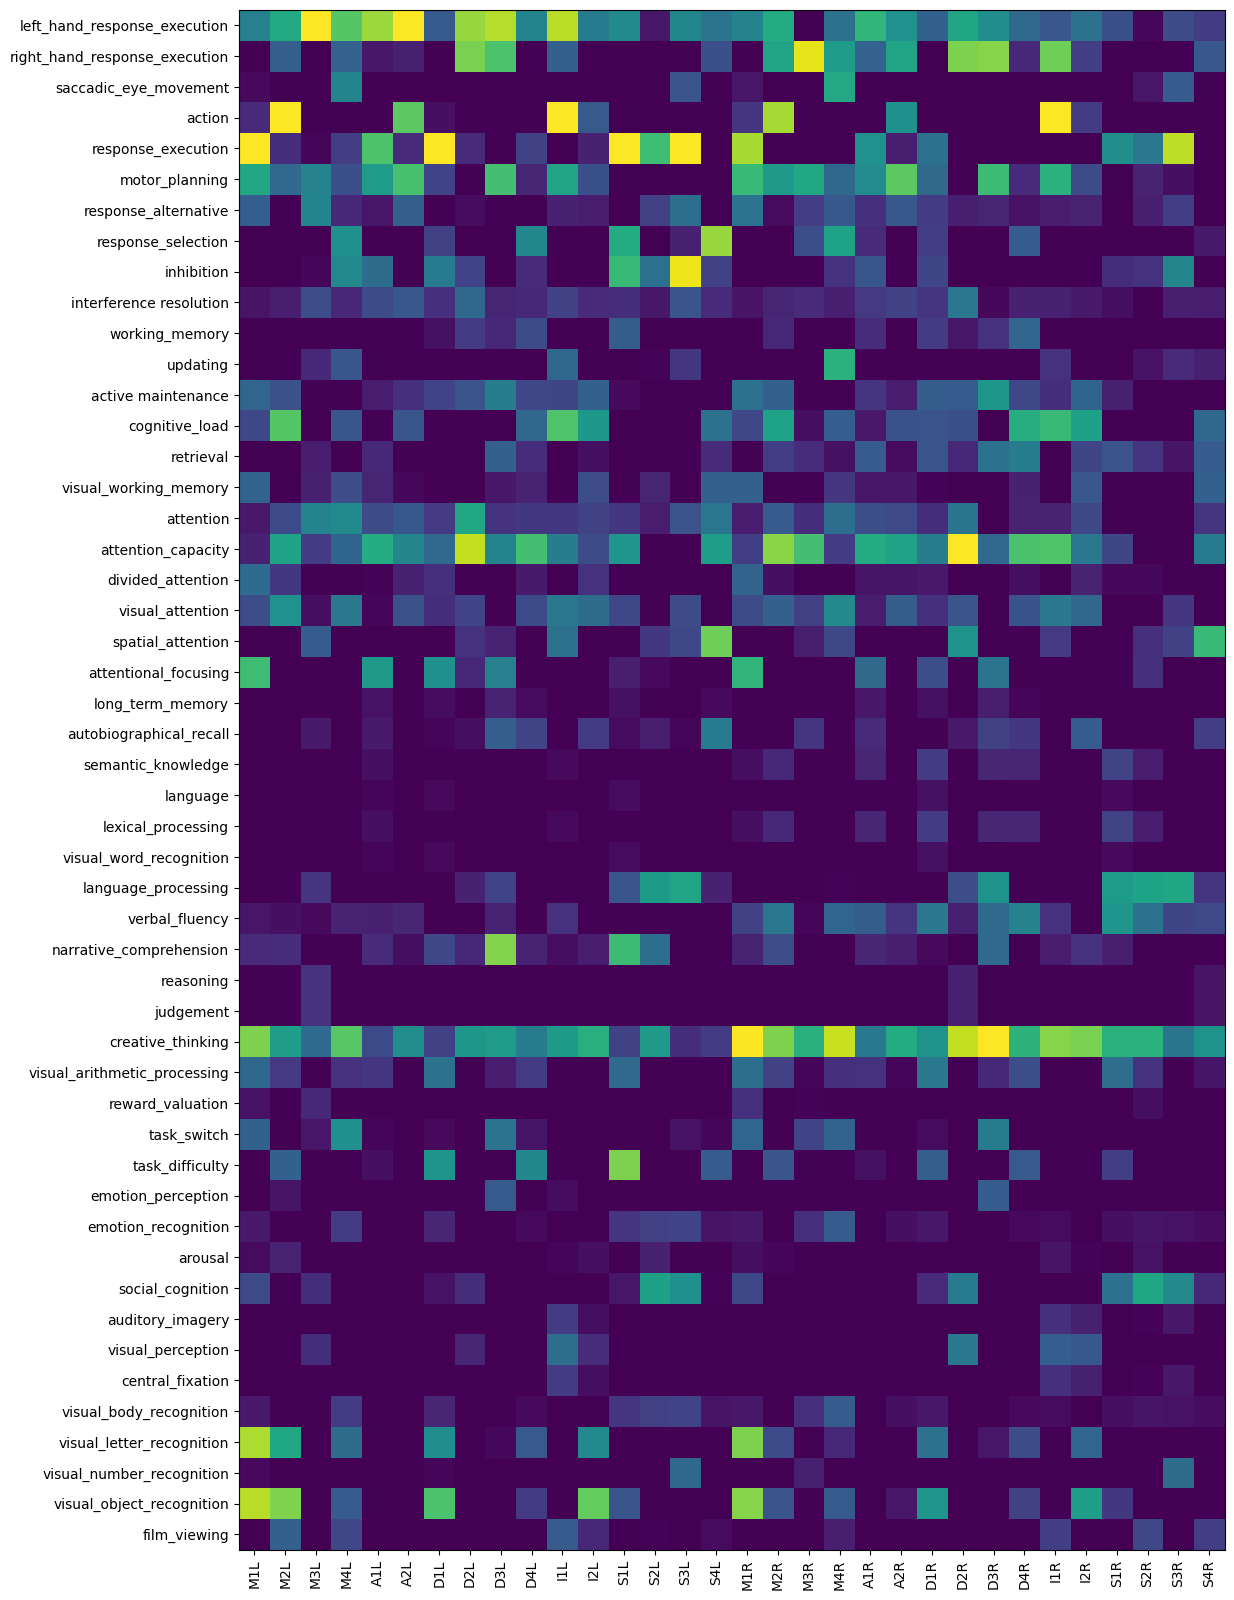

In [17]:
# Plot
plt.figure(figsize=(20, 20))
plt.imshow(features, vmin=0, vmax=0.09)
plt.xticks(np.arange(len(labels)), labels, rotation=90)
plt.yticks(np.arange(len(tags.columns[3:])), tags.columns[3:])


In [23]:
def print_tags(profile, df, labels, region=None, n=5):

    for i, r in enumerate(labels):
        if (region is None) | (r == region):
            print(f'\nregion {r}')

            # Sort conditions by score
            scores = profile[:, i]
            zipped = zip(scores, df.columns)
            zipped = sorted(zipped, key=lambda x: x[0], reverse=True)
            scores, conds = zip(*zipped[:n])

            [print(f'{cond}: {score}')
             for score, cond in zip(scores, conds)]


In [ ]:
# Loop through all regions and print the top 5 tags into a text file
with open(f'{ut.model_dir}/Atlases/Profiles/tags/tags.txt', 'w') as f:
    for r in labels:
        f.write(f'\nregion {r}\n')
        scores = profile[:, labels == r]
        zipped = zip(scores, tags.columns[3:])
        zipped = sorted(zipped, key=lambda x: x[0], reverse=True)
        scores, conds = zip(*zipped[:5])
        [f.write(f'{cond}: {score}\n') for score, cond in zip(scores, conds)]

In [24]:
for region in ['M3R', 'M3L']:
    print_tags(features, Features, labels, region=region, n=10)



region M3R
right_hand_response_execution: 0.08681315656519202
attention_capacity: 0.06296049588006648
creative_thinking: 0.05729669300744659
motor_planning: 0.054025087644066015
response_selection: 0.02164307595415458
task_switch: 0.018125836947410625
visual_attention: 0.01704420671901494
response_alternative: 0.016520305651275543
autobiographical_recall: 0.01378391087686131
emotion_recognition: 0.012046858244495624

region M3L
left_hand_response_execution: 0.11736088465101586
attention: 0.04074066496082115
response_alternative: 0.04056737211589959
motor_planning: 0.04018942598836547
creative_thinking: 0.0316390285472614
spatial_attention: 0.026048823114742447
interference resolution: 0.02131809638955318
attention_capacity: 0.01597961745391967
language_processing: 0.013505986737786153
judgement: 0.012932424189076908


In [26]:
for region in ['M1L', 'M1R']:
    print_tags(features, Features, labels, region=region, n=10)



region M1L
response_execution: 0.09520372761193265
visual_object_recognition: 0.08039458981815258
visual_letter_recognition: 0.07897765495900438
creative_thinking: 0.0723798971133783
attentional_focusing: 0.06189802732964881
motor_planning: 0.05355166214577708
left_hand_response_execution: 0.0393060145443798
divided_attention: 0.031372261197756164
visual_arithmetic_processing: 0.02994053289491494
active maintenance: 0.029276037903473058

region M1R
creative_thinking: 0.08938723046049896
response_execution: 0.07824300248570921
visual_object_recognition: 0.07367630183974731
visual_letter_recognition: 0.07208492983000239
motor_planning: 0.06101164060445006
attentional_focusing: 0.058834507103105844
left_hand_response_execution: 0.04011914351024981
response_alternative: 0.0341927473469416
active maintenance: 0.032909819784875914
visual_arithmetic_processing: 0.032462536233744135


In [27]:
for region in ['M1L', 'M1R']:
    print_tags(features, Features, labels, region=region, n=10)



region M1L
response_execution: 0.09520372761193265
visual_object_recognition: 0.08039458981815258
visual_letter_recognition: 0.07897765495900438
creative_thinking: 0.0723798971133783
attentional_focusing: 0.06189802732964881
motor_planning: 0.05355166214577708
left_hand_response_execution: 0.0393060145443798
divided_attention: 0.031372261197756164
visual_arithmetic_processing: 0.02994053289491494
active maintenance: 0.029276037903473058

region M1R
creative_thinking: 0.08938723046049896
response_execution: 0.07824300248570921
visual_object_recognition: 0.07367630183974731
visual_letter_recognition: 0.07208492983000239
motor_planning: 0.06101164060445006
attentional_focusing: 0.058834507103105844
left_hand_response_execution: 0.04011914351024981
response_alternative: 0.0341927473469416
active maintenance: 0.032909819784875914
visual_arithmetic_processing: 0.032462536233744135


In [29]:
for region in ['S1L', 'S1R']:
    print_tags(features, Features, labels, region=region, n=10)



region S1L
response_execution: 0.12041388466531389
task_difficulty: 0.07225680930112706
narrative_comprehension: 0.06154144053300857
inhibition: 0.060757656612452055
response_selection: 0.05544219151410068
attention_capacity: 0.04695053144436834
left_hand_response_execution: 0.04277166771426817
visual_arithmetic_processing: 0.030912948486715185
working_memory: 0.02657030521827623
visual_object_recognition: 0.023488708513719054

region S1R
creative_thinking: 0.057435837607992125
language_processing: 0.049762505668346536
verbal_fluency: 0.04697305550864035
response_execution: 0.04469376227959355
social_cognition: 0.032900673471066615
visual_arithmetic_processing: 0.032001039418497364
retrieval: 0.02295034705448408
left_hand_response_execution: 0.02193817354350594
attention_capacity: 0.01890620445250462
semantic_knowledge: 0.018382702481851223


In [30]:
for region in ['S2L', 'S2R']:
    print_tags(features, Features, labels, region=region, n=10)



region S2L
response_execution: 0.062224082321927804
social_cognition: 0.051494079840990074
language_processing: 0.04919404963745501
creative_thinking: 0.048216031486352194
inhibition: 0.032893258697638185
narrative_comprehension: 0.03259098829087452
emotion_recognition: 0.0171843313748589
visual_body_recognition: 0.0171843313748588
response_alternative: 0.016973068896783232
spatial_attention: 0.014578840230347024

region S2R
creative_thinking: 0.05737746962549799
social_cognition: 0.052891438817057254
language_processing: 0.05238114134532935
response_execution: 0.03570659835350466
verbal_fluency: 0.03392067601018664
film_viewing: 0.019332368242857192
retrieval: 0.013923366040641798
visual_arithmetic_processing: 0.013168479678647102
inhibition: 0.013141983029212757
attentional_focusing: 0.0124297668148504


In [32]:
for region in ['I1L', 'I1R']:
    print_tags(features, Features, labels, region=region, n=10)



region I1L
action: 0.1322883890632315
left_hand_response_execution: 0.08062994037967755
cognitive_load: 0.06521057005995887
motor_planning: 0.0525485083091573
creative_thinking: 0.04891933145611361
attention_capacity: 0.0376390115605557
visual_attention: 0.036093252559795216
spatial_attention: 0.03307170535895673
visual_perception: 0.0326448732246358
updating: 0.029981784181500864

region I1R
action: 0.11115008706063977
creative_thinking: 0.0734801179608171
right_hand_response_execution: 0.0702767805413783
attention_capacity: 0.06556100171845088
cognitive_load: 0.06086505708908863
motor_planning: 0.05762545249602093
visual_attention: 0.03552294174889554
visual_perception: 0.02691864572408674
left_hand_response_execution: 0.024349414415379154
film_viewing: 0.01662471283545973


In [31]:
for region in ['I2L', 'I2R']:
    print_tags(features, Features, labels, region=region, n=10)



region I2L
visual_object_recognition: 0.06880332654469432
creative_thinking: 0.05651377808217824
cognitive_load: 0.047841218002768214
visual_letter_recognition: 0.04261254440613616
left_hand_response_execution: 0.03745351943500888
visual_attention: 0.0318510597701632
active maintenance: 0.027933268158111632
action: 0.02498205608397529
motor_planning: 0.021906628224419886
visual_working_memory: 0.021160865750781976

region I2R
creative_thinking: 0.07199641165570646
cognitive_load: 0.05158771470451158
visual_object_recognition: 0.0506031652879089
attention_capacity: 0.03599638896211788
left_hand_response_execution: 0.0335141722241607
visual_attention: 0.029878034316304255
visual_letter_recognition: 0.029197308168757097
active maintenance: 0.02883219564418566
autobiographical_recall: 0.026122683769838
visual_perception: 0.024949573001586345


In [34]:
for region in ['D1L', 'D1R']:
    print_tags(features, Features, labels, region=region, n=10)



region D1L
response_execution: 0.10191590160975234
visual_object_recognition: 0.06459638284608143
task_difficulty: 0.04670670775392198
attentional_focusing: 0.04532808508474628
visual_letter_recognition: 0.04412533324129047
inhibition: 0.037186910708744865
visual_arithmetic_processing: 0.03397461733932639
attention_capacity: 0.03077972057781813
left_hand_response_execution: 0.02577754082743114
narrative_comprehension: 0.019306321389612087

region D1R
visual_object_recognition: 0.046987076650679895
creative_thinking: 0.045762687216871226
attention_capacity: 0.03829152043286433
visual_arithmetic_processing: 0.036105616903595705
verbal_fluency: 0.03565409453594313
response_execution: 0.03402424680207537
visual_letter_recognition: 0.03397736156537173
motor_planning: 0.03093861181119892
left_hand_response_execution: 0.027952488809293657
task_difficulty: 0.027199489249159492


In [35]:
for region in ['D2L', 'D2R']:
    print_tags(features, Features, labels, region=region, n=10)



region D2L
attention_capacity: 0.08175099485028287
left_hand_response_execution: 0.07606689061913303
right_hand_response_execution: 0.07174515729090537
attention: 0.05355455804150282
creative_thinking: 0.0474877890829444
interference resolution: 0.02993201872121863
active maintenance: 0.023598637416245953
inhibition: 0.01819303183629485
visual_attention: 0.01818341174597951
working_memory: 0.015576422019256526

region D2R
attention_capacity: 0.09924643557712148
creative_thinking: 0.081655202785807
right_hand_response_execution: 0.07207436594528473
left_hand_response_execution: 0.05289015188800126
spatial_attention: 0.0463502201743068
social_cognition: 0.03749005281904376
visual_perception: 0.03619055304740652
interference resolution: 0.03519420230718988
attention: 0.035076714139069536
active maintenance: 0.025488620560615405


In [36]:
for region in ['D3L', 'D3R']:
    print_tags(features, Features, labels, region=region, n=10)



region D3L
left_hand_response_execution: 0.07993891116640395
narrative_comprehension: 0.07339409956520185
right_hand_response_execution: 0.06466065002362076
motor_planning: 0.06299866524203046
creative_thinking: 0.04924271679756354
attention_capacity: 0.040676787673048095
attentional_focusing: 0.03906543729173709
active maintenance: 0.03830228393565121
task_switch: 0.03425961292099348
retrieval: 0.027443907353843104

region D3R
creative_thinking: 0.09091505716731901
right_hand_response_execution: 0.07380860045926003
motor_planning: 0.06184963246023667
active maintenance: 0.047785619119251145
language_processing: 0.045987050609368293
left_hand_response_execution: 0.044650248420007595
task_switch: 0.037981674321751265
attentional_focusing: 0.03477305952158227
retrieval: 0.034072223922867524
verbal_fluency: 0.030894715283347494


In [37]:
for region in ['A1L', 'A1R']:
    print_tags(features, Features, labels, region=region, n=10)



region A1L
left_hand_response_execution: 0.07646174948765808
response_execution: 0.06503894333122347
attention_capacity: 0.055669949167013524
motor_planning: 0.049229947779037775
attentional_focusing: 0.04817833156521128
inhibition: 0.03194198576634874
attention: 0.020809593058861695
interference resolution: 0.020546692794161492
creative_thinking: 0.020121358668880054
visual_arithmetic_processing: 0.014159373616000077

region A1R
left_hand_response_execution: 0.059242547252112074
attention_capacity: 0.055350576012465416
response_execution: 0.045438066898740005
motor_planning: 0.04328948163936889
creative_thinking: 0.0364396485028027
attentional_focusing: 0.03099780844337457
right_hand_response_execution: 0.02838979402566359
verbal_fluency: 0.026544282505537184
retrieval: 0.02571868255744865
inhibition: 0.023974286607085442


In [38]:
for region in ['A2L', 'A2R']:
    print_tags(features, Features, labels, region=region, n=10)



region A2L
left_hand_response_execution: 0.09087539599909265
action: 0.06736675110333111
motor_planning: 0.0638918766253794
creative_thinking: 0.04407896683908948
attention_capacity: 0.04093637107093072
response_alternative: 0.027178631960414305
attention: 0.024650555829835604
interference resolution: 0.024363549276674213
cognitive_load: 0.024129813097665716
visual_attention: 0.02220693844792014

region A2R
motor_planning: 0.06715439432676755
creative_thinking: 0.055374541623780554
right_hand_response_execution: 0.05248602620670019
attention_capacity: 0.05199147165592231
left_hand_response_execution: 0.045543386817872754
action: 0.045230153220274766
visual_attention: 0.026414235709239745
response_alternative: 0.024863300608592653
cognitive_load: 0.02277851088467058
attention: 0.019760770786719662
